<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/t5/T5ForSequenceClassification_custom_mlflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MLFLOW
https://mlflow.org/docs/latest/introduction/index.html


MLflow is a solution to many of these issues in this dynamic landscape, offering tools and simplifying processes to streamline the ML lifecycle and foster collaboration among ML practitioners.

https://mlflow.org/docs/latest/llms/llm-evaluate/index.html

# MLflow transformers Guide
https://mlflow.org/docs/latest/llms/transformers/guide/index.html
https://mlflow.org/docs/latest/llms/transformers/tutorials/fine-tuning/transformers-fine-tuning.html


# Model
https://huggingface.co/google-t5/t5-base#uses
https://huggingface.co/docs/transformers/en/tasks/sequence_classification

The task illustrated in this tutorial is supported by the following model architectures:
ALBERT, BART, BERT, BigBird, BigBird-Pegasus, BioGpt, BLOOM, CamemBERT, CANINE, CodeLlama, ConvBERT, CTRL, Data2VecText, DeBERTa, DeBERTa-v2, DistilBERT, ELECTRA, ERNIE, ErnieM, ESM, Falcon, FlauBERT, FNet, Funnel Transformer, Gemma, GPT-Sw3, OpenAI GPT-2, GPTBigCode, GPT Neo, GPT NeoX, GPT-J, I-BERT, Jamba, LayoutLM, LayoutLMv2, LayoutLMv3, LED, LiLT, LLaMA, Longformer, LUKE, MarkupLM, mBART, MEGA, Megatron-BERT, Mistral, Mixtral, MobileBERT, MPNet, MPT, MRA, MT5, MVP, Nezha, Nyströmformer, OpenLlama, OpenAI GPT, OPT, Perceiver, Persimmon, Phi, PLBart, QDQBert, Qwen2, Qwen2MoE, Reformer, RemBERT, RoBERTa, RoBERTa-PreLayerNorm, RoCBert, RoFormer, SqueezeBERT, StableLm, Starcoder2, T5, TAPAS, Transformer-XL, UMT5, XLM, XLM-RoBERTa, XLM-RoBERTa-XL, XLNet, X-MOD, YOSO
# T5ForSequenceClassification
Model Loader with a sequence classification head

T5 to classify sequences by using only the encoder of T5 and a ClassificationHead.

# ngrok
Connect localhost to the internet for testing applications and APIs
Bring secure connectivity to apps and APIs in localhost and dev/test environments with just one command or function call.
- Webhook testing
- Developer Previews
- Mobile backend testing

https://ngrok.com/


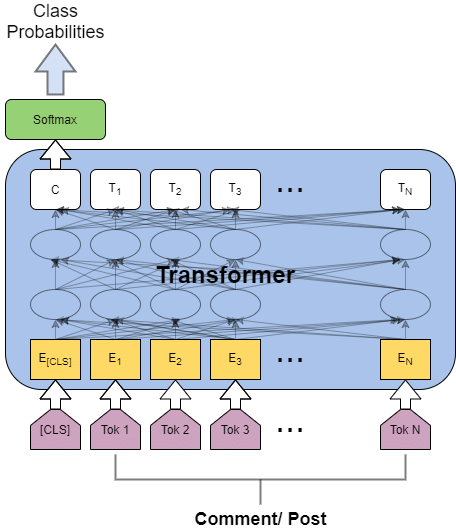

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mlflow pyngrok evaluate  bitsandbytes accelerate datasets transformers==4.39.3 --quiet
get_ipython().system_raw("mlflow ui --port 5000 &")

In [ ]:

from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

In [ ]:
from google.colab import userdata
NGROK_AUTH_TOKEN  = userdata.get('NGROK')

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [ ]:
# Disable tokenizers warnings when constructing pipelines
%env TOKENIZERS_PARALLELISM=false

import warnings

# Disable a few less-than-useful UserWarnings from setuptools and pydantic
warnings.filterwarnings("ignore", category=UserWarning)

### Preparing the Dataset and Environment for Fine-Tuning

#### Key Steps in this Section

1. **Loading the Dataset**: Utilizing the `sms_spam` dataset for spam detection.
2. **Splitting the Dataset**: Dividing the dataset into training and test sets with an 80/20 distribution.
3. **Importing Necessary Libraries**: Including libraries like `evaluate`, `mlflow`, `numpy`, and essential components from the `transformers` library.

Before diving into the fine-tuning process, setting up our environment and preparing the dataset is crucial. This step involves loading the dataset, splitting it into training and testing sets, and initializing essential components of the Transformers library. These preparatory steps lay the groundwork for an efficient fine-tuning process.

This setup ensures that we have a solid foundation for fine-tuning our model, with all the necessary data and tools at our disposal. In the following Python code, we'll execute these steps to kickstart our model fine-tuning journey.

In [ ]:
import evaluate
import numpy as np
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    pipeline,
)

import mlflow
import pandas as pd


In [ ]:
data_path = "/content/drive/MyDrive/data/documents_final_cv.csv"
data = pd.read_csv(data_path, header=None)
data_path_test = "/content/drive/MyDrive/data/documents_test_cv.csv"
data_test= pd.read_csv(data_path_test,  header=None)
data.columns = ["label", "text"]
data_test.columns = ["label", "text"]

In [ ]:
data.head()

In [ ]:
label_dic = {"cv": 1, "non-cv": 0}

In [ ]:
data['label'] = data['label'].map(label_dic)
data_test['label'] = data_test['label'].map(label_dic)

In [ ]:
df_train_test = Dataset.from_pandas(data)
df_val = Dataset.from_pandas(data_test)
df_train_test = df_train_test.train_test_split(test_size=0.2)

In [ ]:
train_dataset = df_train_test["train"]
test_dataset = df_train_test["test"]

In [ ]:
train_dataset

In [ ]:
test_dataset

In [ ]:
train_dataset[0]['text']

In [ ]:
train_dataset[0]['label']

### Tokenization and Dataset Preparation

In the next code block, we tokenize our text data, preparing it for the fine-tuning process of our model.
    
With our dataset loaded and split, the next step is to prepare our text data for the model. This involves tokenizing the text, a crucial process in NLP where text is converted into a format that's understandable and usable by our model.

#### Tokenization Process

- **Loading the Tokenizer**: Using the `AutoTokenizer` from the `transformers` library for the `distilbert-base-uncased` model's tokenizer.
- **Defining the Tokenization Function**: Creating a function to tokenize text data, including padding and truncation.
- **Applying Tokenization to the Dataset**: Processing both the training and testing sets for model readiness.

Tokenization is a critical step in preparing text data for NLP tasks. It ensures that the data is in a format that the model can process, and by handling aspects like padding and truncation, it ensures consistency across our dataset, which is vital for training stability and model performance.

In [ ]:
PROJECT = "T5-Custom"
MODEL_NAME = 'google-t5/t5-base'
DATASET = "CVS-Premcloud"

In [ ]:
MODEL_ID = "google-t5/t5-base"
# Load tokenizer of FLAN-t5
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, model_max_length=512)


In [ ]:
def tokenize_function(examples):
    # Pad/truncate each text to 512 tokens. Enforcing the same shape
    # could make the training faster.
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )


seed = 22

# Tokenize the train and test datasets
train_tokenized = train_dataset.map(tokenize_function)
train_tokenized = train_tokenized.remove_columns(["text"]).shuffle(seed=seed)

test_tokenized = test_dataset.map(tokenize_function)
test_tokenized = test_tokenized.remove_columns(["text"]).shuffle(seed=seed)

# Model Loader with a sequence classification head
https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification

https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSequenceClassification

# T5ForSequenceClassification
Model Loader with a sequence classification head

T5 to classify sequences by using only the encoder of T5 and a ClassificationHead.

In [ ]:
# Set the mapping between int label and its meaning.
id2label = {0: "non-cv", 1: "cv"}
label2id = {"non-cv": 0, "cv": 1}

# Acquire the model from the Hugging Face Hub, providing label and id mappings so that both we and the model can 'speak' the same language.
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    label2id=label2id,
    id2label=id2label,
)

In [ ]:
from transformers import DataCollatorWithPadding, DataCollatorForSeq2Seq
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
data_collator = DataCollatorWithPadding(tokenizer=tokenizer ,  pad_to_multiple_of=8)



In [ ]:
REPOSITORY_ID = f"{MODEL_ID.split('/')[1]}-text-classification"
REPOSITORY_ID

## Compute metrics
### EvalPrediction
https://huggingface.co/docs/transformers/en/internal/trainer_utils
https://discuss.huggingface.co/t/trainer-class-compute-metrics-and-evalprediction/1698

https://github.com/huggingface/transformers/blob/main/src/transformers/trainer_utils.py

In [ ]:

def compute_metrics(eval_preds):
    # load metrics
    metric = evaluate.load("f1")
    metric1 = evaluate.load("roc_auc")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("precision")


    logits, labels = eval_preds
    if isinstance(logits, tuple):
        logits = logits[0]
    predictions = np.argmax(logits, axis=-1)

    result = {}
    result['f1'] = metric.compute(predictions=predictions, references=labels, average='macro')['f1']
    result['roc_auc'] = metric1.compute(prediction_scores=predictions, references=labels, average='macro')['roc_auc']
    result['recall'] = metric2.compute(predictions=predictions, references=labels, average='macro')['recall']
    result['precision'] = metric3.compute(predictions=predictions, references=labels, average='macro')['precision']

    return result

In [ ]:
# Checkpoints will be output to this `training_output_dir`.
training_output_dir = "/tmp/sms_trainer"
training_args = TrainingArguments(
    output_dir=training_output_dir,
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-3,
    weight_decay=0.01,
    logging_steps=8,
    num_train_epochs=4,
    load_best_model_at_end=True,
    save_strategy="epoch",
    metric_for_best_model='eval_loss',
    greater_is_better=False,

)

# Instantiate a `Trainer` instance that will be used to initiate a training run.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# If you are running this tutorial in local mode, leave the next line commented out.
# Otherwise, uncomment the following line and set your tracking uri to your local or remote tracking server.

mlflow.set_tracking_uri("http://127.0.0.1:5000")

### Integrating MLflow for Experiment Tracking

The final preparatory step before beginning the training process is to integrate MLflow for experiment tracking.
   
MLflow is a critical tool in our workflow, enabling us to log, monitor, and compare different runs of our model training.

#### Setting up the MLflow Experiment

- **Naming the Experiment**: We use `mlflow.set_experiment` to create a new experiment or assign the current run to an existing experiment. In this case, we name our experiment "Spam Classifier Training". This name should be descriptive and related to the task at hand, aiding in organizing and identifying experiments later.
- **Role of MLflow in Training**: By setting up an MLflow experiment, we can track various aspects of our model training, such as parameters, metrics, and outputs. This tracking is invaluable for comparing different models, tuning hyperparameters, and maintaining a record of our experiments.

#### Benefits of Experiment Tracking
Utilizing MLflow for experiment tracking offers several advantages:

- **Organization**: Keeps your training runs organized and easily accessible.
- **Comparability**: Allows for easy comparison of different training runs to understand the impact of changes in parameters or data.
- **Reproducibility**: Enhances the reproducibility of experiments by logging all necessary details.

With MLflow set up, we're now ready to begin the training process, keeping track of every important aspect along the way.

In the next code snippet, we'll set up our MLflow experiment for tracking the training of our spam classification model.

In [ ]:
# Pick a name that you like and reflects the nature of the runs that you will be recording to the experiment.
mlflow.set_experiment("T5 Custom Sequence-Classifier Training")

### Starting the Training Process with MLflow

In this step, we initiate the fine-tuning training run, utilizing the native auto-logging functionality to record the parameters used and loss metrics calculated during the training process.
    
With our model, training arguments, and MLflow experiment set up, we are now ready to start the actual training process. This step involves initiating an MLflow run, which will encapsulate all the training activities and metrics.

#### Initiating the MLflow Run

- **Starting an MLflow Run**: We use `mlflow.start_run()` to begin a new MLflow run. This function creates a new run context, under which all the training operations and logging will occur.
- **Training the Model**: Inside the MLflow run context, we call `trainer.train()` to start training our model. This function will run the training loop, processing the data in batches, updating model parameters, and evaluating the model.

#### Monitoring the Training Progress
During training, the `Trainer` object will output logs that provide valuable insights into the training progress:

- **Loss**: Indicates the model's performance, with lower values signifying better performance.
- **Learning Rate**: Shows the current learning rate used during training.
- **Epoch Progress**: Displays the progress through the current epoch.

These logs are crucial for monitoring the model's learning process and making any necessary adjustments. By tracking these metrics within an MLflow run, we can maintain a comprehensive record of the training process, enhancing reproducibility and analysis.

In the next code block, we will start our MLflow run and begin training our model, closely observing the output to gauge the training progress.

In [ ]:
!rm -rf ./flan-T5-fine-tune

In [ ]:
!mkdir ./flan-T5-fine-tune
custom_path = "./flan-T5-fine-tune/"

In [ ]:
with mlflow.start_run() as run:
    train_results = trainer.train()
    print(train_results.metrics)
    trainer.model.save_pretrained(custom_path)
    trainer.data_collator.tokenizer.save_pretrained(custom_path)

    transformers_model = {"model": trainer.model, "tokenizer": trainer.data_collator.tokenizer}
    task = "text-classification"
    model_info = mlflow.transformers.log_model(
        transformers_model=transformers_model,
        artifact_path="text_classifier",
        task=task,
    )
    print(model_info.metadata)


In [ ]:
run.to_dictionary()

In [ ]:
run.data

In [ ]:
import transformers
from mlflow.models import infer_signature
from mlflow.transformers import generate_signature_output
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
model_info.artifact_path

In [ ]:
 model_info.model_uri

In [ ]:
classification_components = mlflow.transformers.load_model(
    model_info.model_uri, return_type="components"
)


In [ ]:
type(classification_components['tokenizer'])

In [ ]:
type(classification_components['model'])

### Loading and Testing the Model from MLflow

After logging our fine-tuned model to MLflow, we'll now load and test it.
    
#### Loading the Model from MLflow

- **Using mlflow.transformers.load_model**: We use this function to load the model stored in MLflow. This demonstrates how models can be retrieved and utilized post-training, ensuring they are accessible for future use.
- **Retrieving Model URI**: We use the `model_uri` obtained from logging the model to MLflow. This URI is the unique identifier for our logged model, allowing us to retrieve it accurately.

#### Testing the Model with Validation Text

- **Preparing Validation Text**: We use a creatively crafted text to test the model's performance. This text is designed to mimic a typical spam message, which is relevant to our model's training on spam classification.
- **Evaluating Model Output**: By passing this text through the loaded model, we can observe its performance and effectiveness in a practical scenario. This step is crucial to ensure that the model works as expected in real-world conditions.

Testing the model after loading it from MLflow is essential for several reasons:

- **Validation of Logging Process**: It confirms that the model was logged and loaded correctly.
- **Practical Performance Assessment**: Provides a real-world assessment of the model's performance, which is critical for deployment decisions.
- **Demonstrating End-to-End Workflow**: Showcases a complete workflow from training, logging, loading, to using the model, which is vital for understanding the entire model lifecycle.

In the next code block, we'll load our model from MLflow and test it with a validation text to assess its real-world performance.

In [ ]:
def load_dataset_test(data_path) -> Dataset:
    """ Load dataset. """
    dataset_ecommerce_pandas = pd.read_csv(data_path, header=None, names=['label', 'text'])
    dataset_ecommerce_pandas['label'] = dataset_ecommerce_pandas['label'].astype(str)
    dataset_ecommerce_pandas['label'] = dataset_ecommerce_pandas['label'].map(label_dic)
    dataset_ecommerce_pandas['text'] = dataset_ecommerce_pandas['text'].astype(str)
    dataset = Dataset.from_pandas(dataset_ecommerce_pandas)

    return dataset

In [ ]:
datatest= load_dataset_test(data_path_test)

In [ ]:
len(datatest)

In [ ]:
datatest[0]

In [ ]:
import torch
from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import classification_report

In [ ]:
reconstructed_pipeline = transformers.pipeline(**classification_components)

In [ ]:
reconstructed_pipeline("this is a text")

In [ ]:
def evaluate_model() -> None:
    """Evaluate the model on the test dataset."""
    predictions_list, labels_list, scores = [], [], []

    samples_number = len(datatest)
    progress_bar = tqdm(range(samples_number))

    for i in range(samples_number):
        text = datatest['text'][i]
        pred_dict= reconstructed_pipeline(text)
        pred = pred_dict[0].get("label")
        pred = 1 if pred == "cv" else 0
        predictions_list.append(pred)
        scores.append(pred_dict[0].get("score"))
        labels_list.append(int(datatest['label'][i]))

        progress_bar.update(1)

    report = classification_report(labels_list, predictions_list)
    print(report)
    return predictions_list, labels_list, scores

In [ ]:
predictions_list, labels_list, scores = evaluate_model()

In [ ]:
from sklearn import metrics

In [ ]:
confusion_matrix = metrics.confusion_matrix(labels_list, predictions_list)

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["non-cv", "cv"])

In [ ]:
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

In [ ]:
ngrok.kill()